## Unmet targets workflow  

### Identify unmet targets: 
    File output_mvbest, columns 'Target Met' + 'MPM' (Minimum Proportion Met)

### Worfflow for unmet solutions:
    If the feature is not met but by very little --> mark as met or decrease MISSLEVEL 
    Else:
        If the feature is in locked-out planning units --> Send warning/mark as met/rethink problem
        Else:
            If the feature is in a high cost area --> Increase SPF
            Else:
                The feature has low range and is isolated --> Increase SPF


In [52]:
%run marxan_utils.ipynb 

### Helper functions

In [57]:
def locatePU(MARXAN_FOLDER:str,MARXAN_INPUTDATA:str,pus_of_interest=None, feature=None) -> dict:
    """ Check if feature is in an area of interest
    """
    userInputFile = readInput(MARXAN_FOLDER,MARXAN_INPUTDATA)
    puvsp = validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, planningUnitVSConservationFeatureV)
    
    feature_in_pu=puvsp[(puvsp['species']==feature) & (puvsp.pu.isin(pus_of_interest))]
    
    if len(feature_in_pu)== 0: 
        percentage_in_pu = 0
    else:
        amount_total = puvsp[puvsp['species']==feature].groupby(['species']).sum('amount').reset_index().amount.values[0]
        amount_in_pu= feature_in_pu.groupby('species').sum('amount').reset_index().amount.values[0]
        percentage_in_pu = round((amount_in_pu/amount_total)*100,2)
    return percentage_in_pu

def unmetDecisionTree(MARXAN_FOLDER, MARXAN_INPUTDATA,
                      lock_out_limit=50, 
                      high_cost_quantile= 0.7, 
                      hcost_limit=20):
    
    """Follow the decision flow:
    - Check if the target is missed by little (already considering the defined misslevel)
    - Check if the feature is in a locked-out area 
    - Check if the feature is in a high cost area
    - Check if the feature is very isolated or the range of the feature is very small
    
    Parameteres:
    - threshold met: when to consider a target as met (dy default the misslevel set at input.dat)
    - lock_out_limit: amount of the feature pu's that are in locked out areas that trigger response
    - high_cost_quantile: decide what is high cost
    - hcost_limit: amount of the feature pu's that are in high cost areas that trigger response
    """
    
    # Validate and read files
    userInputFile = readInput(MARXAN_FOLDER,MARXAN_INPUTDATA)
    pu = validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, planningUnits)
    puvsp = validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, planningUnitVSConservationFeatureV)
    mvbest= validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, OutputMV)
    
    df = mvbest[['Conservation_Feature','Target_Met','MPM']].copy()
    threshold_met = userInputFile.MISSLEVEL
    
    if len(df.loc[df['Target_Met']=='no','Conservation_Feature'])==0:
        unmet = {'None':'All targets met'}
    else: 
        for feature in list(df.loc[df['Target_Met']=='no','Conservation_Feature'].values):
        
            # 1. Close to target 
            # Solution: 
            # - Mark as met: Modify output_mvbest.csv (Target Met) MPM: minimum proportion met
            # - Decrease MISSLEVEL (input.dat)
            if (df.loc[df['Conservation_Feature']==feature,'MPM']>=threshold_met-(threshold_met*1/100)).bool():
                df.loc[df['Conservation_Feature']==feature,'Eval']='Close to target (1% away of misslevel)'

            else:
        
            # 2. In lock-out areas (re-think problem)
            # Solution: 
            # - Rethink problem (Assume not met)
            # - Unblock lock-out pu: Modifir pu.dat (status)
        
                pu_excluded = list(pu[pu['status']==3].id) 
                excluded_per = locatePU(MARXAN_FOLDER,MARXAN_INPUTDATA,pus_of_interest=pu_excluded, feature=feature)
                if excluded_per > lock_out_limit: df.loc[df['Conservation_Feature']==feature,'Eval'] = f'{excluded_per} % in locked-out areas'
            
                else:
                        
            # 3. In high cost areas (increase SPF)
            # Solution: 
            # - Increase SPF: Modify spec.dat (spf)
        
                    pu_hcost = list(pu[pu['cost']>pu['cost'].quantile([high_cost_quantile], interpolation='nearest').values[0]].id)
                    hcost_per = locatePU(MARXAN_FOLDER,MARXAN_INPUTDATA,pus_of_interest=pu_excluded, feature=feature)
                    if hcost_per > hcost_limit: df.loc[df['Conservation_Feature']==feature,'Eval'] = f'{hcost_per} % in high cost areas'
                
                    else:
        
            # 4. Small range or isolated 
            # Solution:
            # - Increase SPF: Modify spec.dat (spf)
                        feat_range = round(puvsp[puvsp['species']==feature].count().pu/len(pu)*100,2)
                        df.loc[df['Conservation_Feature']==feature,'Eval'] = f'Small range ({feat_range} % of planning area) or isolated'     
        
            unmet = dict(zip(df[df['Target_Met']=='no'].Conservation_Feature, df[df['Target_Met']=='no'].Eval))
    return unmet

In [7]:
### Next step is to modify input the files according to this output, to run marxan again

## Example data

In [70]:
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_Targets/example_1_Papua'
MARXAN_INPUTDATA = 'input.dat'

In [71]:
df = gapAnalysis(MARXAN_FOLDER, 'input.dat')

In [72]:
df.head()

,id,target,prop,name,amount_total,amount_target,amount_lock,prop_lock,target_met_pre,Target,Amount_Held,Occurrence_Target,Occurrences_Held,Separation_Target,Separation_Achieved,Target_Met,MPM,prop_best,prop_best_minus_lock
0,8,8.700000e+01,0.2,0,4.350000e+02,8.700000e+01,12.0,0.027586,yes,1.166000e+02,1.220000e+02,0.0,122.0,0.0,0.0,yes,1.0,0.280460,0.252874
1,9,1.440000e+01,0.2,0,7.200000e+01,1.440000e+01,0.0,0.000000,no,1.082000e+02,1.840000e+02,0.0,184.0,0.0,0.0,yes,1.0,2.555556,2.555556
2,10,7.340000e+01,0.2,0,3.670000e+02,7.340000e+01,0.0,0.000000,no,8.840000e+01,8.900000e+01,0.0,89.0,0.0,0.0,yes,1.0,0.242507,0.242507
3,30012,8.763336e+07,0.1,0,8.763336e+08,8.763336e+07,0.0,0.000000,no,8.763336e+07,2.054090e+08,0.0,10.0,0.0,0.0,yes,1.0,0.234396,0.234396
4,30013,1.137523e+03,0.1,0,1.137523e+04,1.137523e+03,0.0,0.000000,no,3.306621e+07,5.179875e+07,0.0,3.0,0.0,0.0,yes,1.0,4553.646046,4553.646046


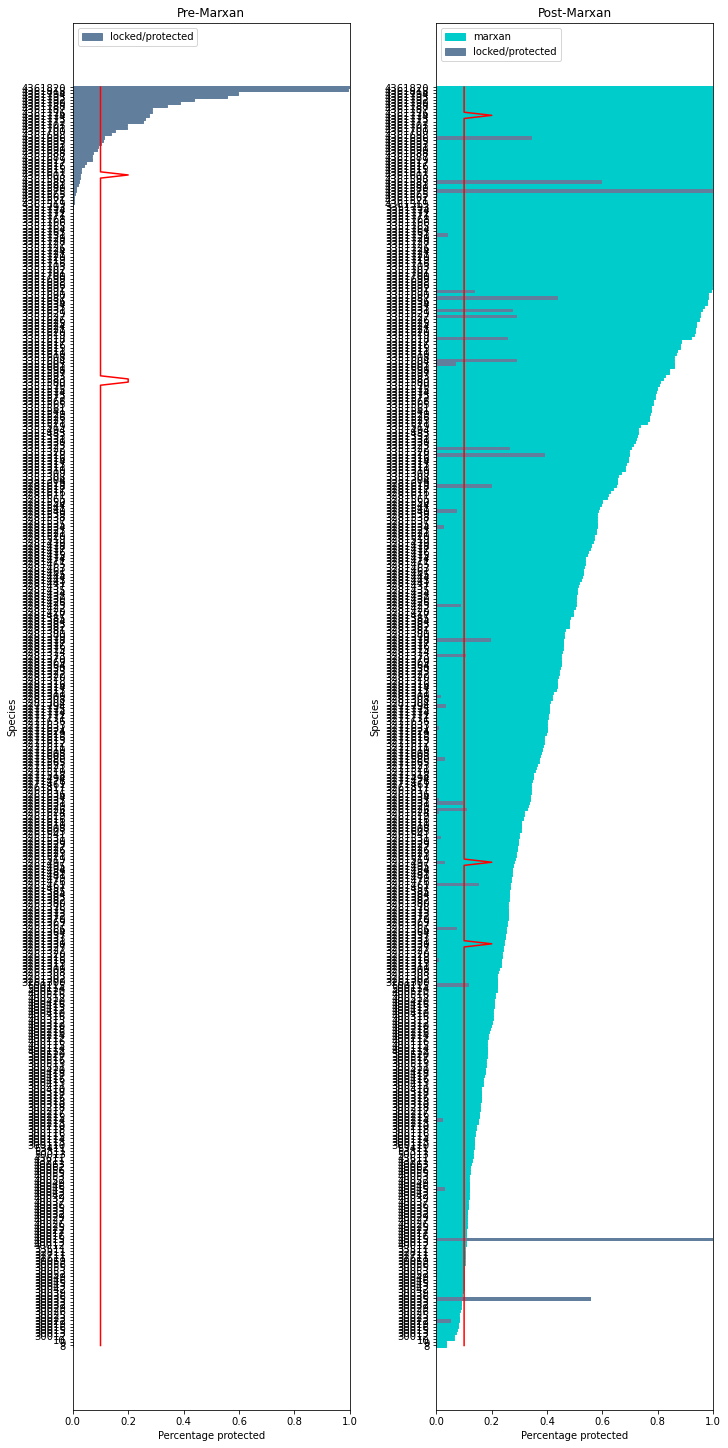

In [58]:
fig, anx = plt.subplots(nrows=1, ncols=2,figsize=(10,20), constrained_layout=True)
plotGap(df, 'Pre-Marxan', anx[0], post_marxan=False)
plotGap(df, 'Post-Marxan', anx[1], post_marxan=True)

In [55]:
unmet_dict = unmetDecisionTree(MARXAN_FOLDER, MARXAN_INPUTDATA,
                      lock_out_limit=50, 
                      high_cost_quantile= 0.7, 
                      hcost_limit=20)

In [56]:
unmet_dict

{2: 'Close to target (1% away of misslevel)',
 6: 'Close to target (1% away of misslevel)',
 8: 'Close to target (1% away of misslevel)'}

#### SPF calibration

In [24]:
def createFpfProject(MARXAN_FOLDER: str, MARXAN_INPUTDATA:str, unmet_dict: dict) -> list:
    
    ### RUN MARXAN several times
    fpf_range= [1,2,5,10,20,50,100]
    fpf_folder=[]

    for fpf in fpf_range:
        print(f'\033[1m --> Running FPF_{fpf}...\033[0m')
        
        ## Create a folder for each FPF run at the same level as the original folder, 
        ## remove  folder if there is a previous one
        ## copy all  files except outputs
        if os.path.exists(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}'):
            rmtree(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}')
        copytree(MARXAN_FOLDER, f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}',ignore=ignore_patterns('output_*'))
        
            
        ## Read input files
        userInputFile = readInput(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}', MARXAN_INPUTDATA)
        userInputFile.NUMREPS = 10
        userInputFile.VERBOSITY = 0
        saveInput(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}', MARXAN_INPUTDATA,userInputFile)
        
        spec = validateFile(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}',MARXAN_INPUTDATA, conservationFeature)
        
        unmet = list(unmet_dict.keys())
        for feature in unmet:
            spec.loc[spec['id'] == feature,'spf'] = (spec[spec['id'] == feature].spf)*fpf
        CreateFileFromDF(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}/{userInputFile.INPUTDIR}/{userInputFile.SPECNAME}',spec, conservationFeature) 
        
        if not os.path.exists(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}/{userInputFile.OUTPUTDIR}'):
            os.mkdir(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}/{userInputFile.OUTPUTDIR}')

        fpf_folder.append(f'FPF_{fpf}')
        os.chmod(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}/marxan', 0o755)
        execute_marxan(f'{os.path.dirname(MARXAN_FOLDER)}/FPF_{fpf}')
    
    return fpf_folder

In [61]:
def FPF_calibration(MARXAN_FOLDER: str, MARXAN_INPUTDATA :str, unmet_dict: dict, Plot: bool = True)-> float:
    fpf_df =pd.DataFrame(columns=['folder','multiplier','missed_targets'])
    fpf_folder = createFpfProject(MARXAN_FOLDER, MARXAN_INPUTDATA, unmet_dict)
    fpf_df['folder'] = fpf_folder
    fpf_df['multiplier']= [int(i.split('_')[1]) for i in fpf_folder]

    for fpf in fpf_folder:
        # using mvbest
        mvbest = validateFile(f'{os.path.dirname(MARXAN_FOLDER)}/{fpf}',MARXAN_INPUTDATA, OutputMV)
        fpf_df.loc[fpf_df['folder']==fpf,'missed_targets']= len(mvbest[mvbest['Target_Met'] == 'no'])
        
        # using an average of all the runs
        # summary = validateFile(f'{os.path.dirname(MARXAN_FOLDER)}/{fpf}',MARXAN_INPUTDATA, OutputSum)
        # fpf_df.loc[blm_df['folder']==fpf,'missed_targets']= summary['Missing_Values'].mean()
    
    ###Curve with no fit
    y = fpf_df['missed_targets']
    x = fpf_df['multiplier']

    best_fpf = fpf_df.loc[fpf_df['missed_targets'] == min(fpf_df.missed_targets),'multiplier'].values[0]
    
    if Plot==True:
        fig = plt.figure(figsize=(5,5))
        plt.xlabel('FPF multiplier')
        plt.ylabel('Missed targets')
        plt.plot(x, y, 'bo-')
        
    return best_fpf

In [43]:
#MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/demo_marxan_okavango/Marxan_okavango_v5'
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/marxan_Coral_Triangle_Case_Study'
MARXAN_INPUTDATA = 'input.dat'

In [53]:
userInputFile = readInput(MARXAN_FOLDER, MARXAN_INPUTDATA)
userInputFile

inputDatFile(VERSION='0.1', BLM=0.0, PROP=0.5, RANDSEED=-1, NUMREPS=10, BESTSCORE=10, NUMITNS=1000000, STARTTEMP=-1, COOLFAC=6, NUMTEMP=10000, COSTTHRESH=0.0, THRESHPEN1=14.0, THRESHPEN2=1.0, INPUTDIR='input', SPECNAME='spec.dat', PUNAME='pu.dat', PUVSPRNAME='puvspr.dat', BOUNDNAME='boundary.dat', BLOCKDEFNAME='blockdef.dat', VERBOSITY=0, MISSLEVEL=1.0, OUTPUTDIR='output', SCENNAME='output', SAVERUN=3, SAVEBEST=3, SAVESUMMARY=3, SAVESCEN=3, SAVETARGMET=3, SAVESUMSOLN=3, SAVELOG=2, SAVESNAPSTEPS=0, SAVESNAPCHANGES=0, SAVESNAPFREQUENCY=0, SAVESOLUTIONSMATRIX=3, RUNMODE=1, ITIMPTYPE=0, HEURTYPE=-1, CLUMPTYPE=0)

In [54]:
os.chmod(f'{MARXAN_FOLDER}/marxan', 0o755)
execute_marxan(MARXAN_FOLDER)

Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

Marxan website

https://marxansolutions.org/

Running multithreaded over number of threads: 4

Best run: 1 Best score: 3.89587e+07


 --> Running FPF_2...
Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

Marxan website

https://marxansolutions.org/

Running multithreaded over number of threads: 4

Best run: 10 Best score: 3.91206e+07
 --> Running FPF_5...
Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

Marxan website

https://marxansolutions.org/

Running multithreaded over number of threads: 4

Best run: 1 Best score: 3.89549e+07
 --> Running FPF_10...
Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

Marxan website

https://marxansolutions.org/

Running multithreaded over number of threads: 4

Best run: 4 Best score: 3.91791e+07
 --> Running FPF_20...
Marxan v 4.0.5

Spatial Prioritization via Annealing

Coded by Ian Ball, modified by Matthew Wat

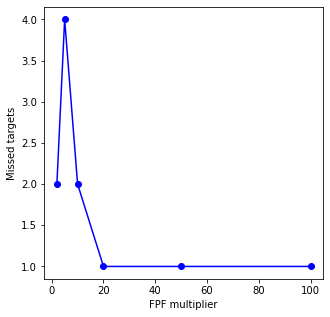

In [69]:
best_multiplier = FPF_calibration(f'{MARXAN_FOLDER}',MARXAN_INPUTDATA, unmet_dict)